# Graph analysis for a legislature

## Config

In [97]:
import json, os, sys, math, requests, re, random, io
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import networkx as nx
from collections import Counter
import matplotlib.lines as mlines
from itertools import combinations


### Load the JSON files and create the graph

In [98]:
def load_data(deputies_path, votes_path):
    with open(deputies_path, 'r', encoding='utf-8') as f:
        deputies = json.load(f)
    with open(votes_path, 'r', encoding='utf-8') as f:
        votes = json.load(f)
    return {"deputies": deputies, "votes": votes}

In [99]:
def create_graph(deputies, votes):
    G = nx.Graph()
    for deputy_id, deputy_info in deputies.items():
        G.add_node(deputy_id, name=deputy_info.get('name', 'Unknown'))
    
    co_votes = {}
    deputy_votes = {}
    
    for vote_id, vote_data in votes.items():
        pour_voters = vote_data['votes_for']
        all_voters = set(pour_voters + vote_data['votes_against'] + vote_data['votes_abs'])
        
        for deputy in all_voters:
            if deputy not in deputy_votes:
                deputy_votes[deputy] = set()
            deputy_votes[deputy].add(vote_id)
        
        for i in range(len(pour_voters)):
            for j in range(len(pour_voters)):
                if i != j:
                    deputy1 = pour_voters[i]
                    deputy2 = pour_voters[j]
                    if G.has_node(deputy1) and G.has_node(deputy2):
                        pair = tuple(sorted([deputy1, deputy2]))
                        co_votes[pair] = co_votes.get(pair, 0) + 0.5 

    for (deputy1, deputy2), pour_count in co_votes.items():
        common_votes = deputy_votes.get(deputy1, set()) & deputy_votes.get(deputy2, set())
        total_common = len(common_votes)
        if total_common > 0:
            percentage = pour_count / total_common
            G.add_edge(deputy1, deputy2, weight=percentage)
            
    return G

In [100]:
legislature_17 = load_data('data/processed/deputees_17.json', 'data/processed/vote_17.json')
legislature_16 = load_data('data/processed/deputees_16.json', 'data/processed/vote_16.json')
legislature_15 = load_data('data/processed/deputees_15.json', 'data/processed/vote_15.json')
legislature_14 = load_data('data/processed/deputees_14.json', 'data/processed/vote_14.json')

## Utils functions

In [101]:
def print_stats(G):
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    if nx.is_connected(G):
        print("Graph is connected")
    else:
        print(f"Graph has {nx.number_connected_components(G)} connected components")

def get_giant_component(G):
    gcc_nodes = max(nx.connected_components(G), key=len)
    return G.subgraph(gcc_nodes).copy()

In [ ]:
def plot_network(G, deputies, legislature_num):
    # Extract node colors and party names
    nodes_color = [deputies[node].get('organ', {}).get('color', '#cccccc') for node in G.nodes()]
    party_colors = {deputies[node].get('organ', {}).get('color', '#cccccc'): deputies[node].get('organ', {}).get('name', 'No name') for node in G.nodes()}

    # Normalize edge widths for display
    raw_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_w = max(raw_weights) if raw_weights else 1
    widths = [(w / max_w) for w in raw_weights]

    # Create a temporary graph to exaggerate weights for the physics simulation
    G_layout = G.copy()
    for u, v, data in G_layout.edges(data=True):
        data['weight'] = data['weight'] ** 2  # Squaring creates stronger gravity for high weights

    plt.figure(figsize=(12, 8))

    # k=0.5 is the optimal distance (lower k = tighter clusters)
    pos = nx.spring_layout(G_layout, k=0.5, iterations=50, weight='weight', seed=42)

    nx.draw(G, pos, node_size=100, node_color=nodes_color, edge_color='lightgray', 
            alpha=0.7, with_labels=False, width=widths)

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=name, 
                      markerfacecolor=color, markersize=10) 
                      for color, name in party_colors.items()]

    plt.legend(handles=legend_handles, title="Political Parties", 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title(f"Deputy Voting Network ({str(legislature_num)}'th Legislature)")
    plt.tight_layout()
    plt.show()

In [142]:
def plot_degree_distribution(G):
    degrees = dict(G.degree(weight='weight'))
    degree_values = list(degrees.values())
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].hist(degree_values, bins=50, alpha=0.7, edgecolor='black')
    degree_counts = Counter(degree_values)
    ks = sorted(degree_counts.keys())
    counts = [degree_counts[k] for k in ks]
    axes[1].loglog(ks, counts, 'o', markersize=6, alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
def detect_communities(G, legislature_num):
    # Detect communities using Louvain
    communities_set = nx.community.louvain_communities(G, weight="weight")
    num_communities = len(communities_set)
    
    # Map nodes to community IDs
    partition = {}
    for community_id, nodes in enumerate(communities_set):
        for node in nodes:
            partition[node] = community_id
    
    # Define colormap
    if num_communities <= 10:
        cmap = plt.cm.get_cmap('tab10', num_communities)
    else:
        cmap = plt.cm.get_cmap('viridis', num_communities)
        
    nodes_color_com = [cmap(partition[node]) for node in G.nodes()]
    
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Community {i}', 
                      markerfacecolor=cmap(i), markersize=10) for i in range(num_communities)]

    # Create a temporary graph to exaggerate weights for the physics simulation
    G_layout = G.copy()
    for u, v, data in G_layout.edges(data=True):
        data['weight'] = data['weight'] ** 2

    plt.figure(figsize=(12, 8))
    
    # k=0.5 allows nodes to cluster tighter based on the squared weights
    pos = nx.spring_layout(G_layout, k=0.5, iterations=50, weight='weight', seed=42)
    
    nx.draw(G, pos, node_size=100, node_color=nodes_color_com, edge_color='lightgray',
            alpha=0.7, with_labels=False, width=0.1)
            
    plt.legend(handles=legend_handles, title="Computed communities", 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Deputy Voting Network - Louvain Communities ({str(legislature_num)}'th Legislature)")
    plt.tight_layout()
    plt.show()

    print(f'Number of communities: {len(communities_set)}')
    modularity_score = nx.community.modularity(G, communities_set, weight='weight')
    print(f"Modularity score: {modularity_score}")
    
    return communities_set, modularity_score

In [105]:
def get_party_info(deputies):
    organ_name_dict = {}
    partis_members = {}
    for dep_id, data in deputies.items():
        if data['organ']:
            organ_id = data['organ']['id']
            organ_name_dict[organ_id] = (data['organ']['name'], data['organ']['name_short'])
            if organ_id not in partis_members:
                partis_members[organ_id] = []
            partis_members[organ_id].append(dep_id)
    return organ_name_dict, partis_members

In [106]:
def plot_community_matrix(partis_members, communities_set, organ_name_dict, all_member_ids):
    communities_dict = {f"C{i}": comm for i, comm in enumerate(communities_set)}
    community_tuples = []
    sorted_comm_keys = sorted(communities_dict.keys())
    for comm_key in sorted_comm_keys:
        comm_set = communities_dict[comm_key]
        members_in_comm = [item for item in comm_set if item in all_member_ids]
        community_tuples.append((comm_key, members_in_comm))
    
    party_member_lists = list(partis_members.values())
    num_parti = len(party_member_lists)
    num_commu = len(community_tuples)
    D = np.empty(shape=(num_parti, num_commu))

    for i in range(num_parti):
        party_i_members = party_member_lists[i]
        for j in range(num_commu):
            community_j_members = community_tuples[j][1]
            intersection = [d for d in community_j_members if d in party_i_members]
            D[i, j] = len(intersection)
            num_party_members = len(party_i_members)
            if num_party_members > 0:
                D[i, j] *= 100 / num_party_members
            else:
                D[i, j] = 0

    x_labels = [f"{t[0]}\n(Size: {len(t[1])})" for t in community_tuples]
    y_labels = [organ_name_dict[g][1] for g in list(partis_members.keys())]
    
    plt.figure(figsize=(max(8, num_commu * 2.5), max(6, num_parti * 0.8)))
    sns.heatmap(D, annot=True, fmt='.0f', cmap='viridis', xticklabels=x_labels, yticklabels=y_labels)
    plt.title('Normalized by Party Size (%)')
    plt.tight_layout()
    plt.show()

In [107]:
def analyze_party_proximity(G, partis_members, organ_name_dict, deputies, plot):
    list_partis = list(partis_members.keys())
    proximites_partis = {}
    proximites_without_parties = {} # Between parties
    
    # Between parties
    for i in range(len(list_partis)-1):
        for j in range(i+1, len(list_partis)):
            proximites = []
            for member_i in partis_members[list_partis[i]]:
                for member_j in partis_members[list_partis[j]]:
                    if G.has_node(member_i) and G.has_node(member_j):
                        weigth = 0
                        if G.has_edge(member_i, member_j):
                            weigth = G[member_i][member_j]['weight']

                        proximites_without_parties[(member_i, member_j)] = weigth
                        proximites.append(weigth)
            if proximites:
                proximites_partis[(list_partis[i], list_partis[j])] = np.mean(proximites)

    # Total 
    proximites_debuties = {}
    for i, j in combinations(G.nodes(), 2):
        weight = 0
        if G.has_edge(i, j):
            weight = G[i][j]['weight']
        proximites_debuties[(i, j)] = weight

    # Within parties
    proximites_within_parties = {}
    for parti in list_partis:
        members = [m for m in partis_members.get(parti, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            proximites_within_parties[(m1, m2)] = weight

    # Of parties
    proximites_of_parties = {}
    for parti in list_partis:
        members = [m for m in partis_members.get(parti, []) if G.has_node(m)]
        if len(members) < 2:
            continue
        tmp = {}
        for m1, m2 in combinations(members, 2):
            weight = 0
            if G.has_edge(m1, m2):
                weight = G[m1][m2]['weight']
            tmp[(m1, m2)] = weight
        party_name = organ_name_dict.get(parti, (parti, parti))[1]
        proximites_of_parties[parti] = {"parti": parti, "name": party_name, "combinations": tmp}
        
    if plot:
        G_partis = nx.Graph()
        labels_dict = {}
        for parti_id, members in partis_members.items():
            nom_parti = organ_name_dict.get(parti_id, (parti_id, parti_id))[1]
            G_partis.add_node(parti_id, count=len(members), label_name=nom_parti)
            labels_dict[parti_id] = f"{nom_parti}\n({len(members)})"

        for (p1, p2), dist in proximites_partis.items():
            safe_dist = dist if dist > 0.01 else 0.01
            G_partis.add_edge(p1, p2, distance=dist, weight=1.0/safe_dist)

        node_colors = []
        for parti_id in G_partis.nodes():
            color = '#cccccc'
            members = partis_members.get(parti_id, [])
            if members and members[0] in deputies:
                color = deputies[members[0]].get('organ', {}).get('color', '#cccccc')
            node_colors.append(color)

        plt.figure(figsize=(14, 10))
        pos = nx.spring_layout(G_partis, weight='weight', k=0.6, seed=42)
        nx.draw_networkx_nodes(G_partis, pos, node_size=[G_partis.nodes[n]['count'] * 50 for n in G_partis.nodes()], node_color=node_colors, alpha=0.9, edgecolors='white')
        nx.draw_networkx_labels(G_partis, pos, labels=labels_dict, font_size=8, font_weight='bold')
        nx.draw_networkx_edges(G_partis, pos, width=1, alpha=0.3, edge_color='gray')
        plt.axis('off')
        plt.show()
        
        parties_ids = list(G_partis.nodes())
        parties_names = [G_partis.nodes[pid]['label_name'] for pid in parties_ids]
        dist_matrix = pd.DataFrame(np.nan, index=parties_names, columns=parties_names)
        for (p1, p2), dist in proximites_partis.items():
            if p1 in parties_ids and p2 in parties_ids:
                name1 = G_partis.nodes[p1]['label_name']
                name2 = G_partis.nodes[p2]['label_name']
                dist_matrix.loc[name1, name2] = dist
                dist_matrix.loc[name2, name1] = dist
                
        plt.figure(figsize=(14, 12))
        sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap="viridis_r", linewidths=0.5)
        plt.title("Proximity matrix between parties")
        plt.show()

    print(len(proximites_partis), len(proximites_without_parties), len(proximites_debuties), len(proximites_within_parties), len(proximites_of_parties))

    return proximites_partis, proximites_without_parties, proximites_debuties, proximites_within_parties, proximites_of_parties

In [108]:
def calculate_party_modularity(G, partis_members):
    nodes_in_graph = set(G.nodes())
    cleaned_parti_com = []
    for members in partis_members.values():
        valid_members = [m for m in members if m in nodes_in_graph]
        if valid_members:
            cleaned_parti_com.append(valid_members)
    print(f"Modularity score - partis : {nx.community.modularity(G, cleaned_parti_com, weight='weight')}")

In [109]:
def get_proximity_stats(proximities):
    values = list(proximities.values())
    if not values:
        return {}
    return {
        "min": np.min(values),
        "max": np.max(values),
        "mean": np.mean(values),
        "median": np.median(values)
    }

def plot_proximity_evolution(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    stats_17 = get_proximity_stats(proximites_partis_17)
    stats_16 = get_proximity_stats(proximites_partis_16)
    stats_15 = get_proximity_stats(proximites_partis_15)
    stats_14 = get_proximity_stats(proximites_partis_14)

    print("Stats 17:", stats_17)
    print("Stats 16:", stats_16)
    print("Stats 15:", stats_15)
    print("Stats 14:", stats_14)

    legs = [14, 15, 16, 17]
    all_stats = [stats_14, stats_15, stats_16, stats_17]

    mins = [s['min'] for s in all_stats]
    maxs = [s['max'] for s in all_stats]
    means = [s['mean'] for s in all_stats]
    medians = [s['median'] for s in all_stats]

    plt.figure(figsize=(10, 6))
    plt.plot(legs, mins, marker='o', label='Min')
    plt.plot(legs, maxs, marker='o', label='Max')
    plt.plot(legs, means, marker='o', label='Mean')
    plt.plot(legs, medians, marker='o', label='Median')

    plt.xlabel('Legislature')
    plt.ylabel('Proximity')
    plt.title('Evolution of Party Proximity Statistics')
    plt.xticks(legs)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_proximity_distributions(proximites_partis_17, proximites_partis_16, proximites_partis_15, proximites_partis_14):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    prox_list = [
        (17, proximites_partis_17),
        (16, proximites_partis_16),
        (15, proximites_partis_15),
        (14, proximites_partis_14)
    ]

    for i, (leg, prox) in enumerate(prox_list):
        vals = list(prox.values())
        sns.histplot(vals, kde=True, ax=axes[i], stat="density")
        axes[i].set_title(f'Legislature {leg}')

    plt.tight_layout()
    plt.show()

def plot_proximity_comparison(prox_between, prox_total, prox_within, prox_of_parties, deputies, legislature_id):
    plt.figure(figsize=(14, 9))
    
    sns.kdeplot(list(prox_between.values()), label='Between Parties', fill=True, alpha=0.1, color='grey', linestyle='--', linewidth=2)
    sns.kdeplot(list(prox_within.values()), label='Within Parties (All)', fill=True, alpha=0.1, color='black', linewidth=2)
    #sns.kdeplot(list(prox_total.values()), label='Total', fill=True, alpha=0.1)

    party_colors = {}
    for dep in deputies.values():
        if dep.get('organ'):
            party_colors[dep['organ']['id']] = dep['organ'].get('color', '#cccccc')

    for party_id, data in prox_of_parties.items():
        vals = list(data['combinations'].values())
        if len(vals) > 5: # Filter slightly to avoid KDE errors on very few points
            color = party_colors.get(party_id, '#cccccc')
            sns.kdeplot(vals, label=f"{data['name']}", color=color, linestyle=':', linewidth=3.5, alpha=0.9)

    plt.title(f'Distribution of Deputy Proximities - Legislature {legislature_id}', fontsize=16)
    plt.xlabel('Proximity (Weight)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

## Setup

In [110]:
G_17 = get_giant_component(create_graph(legislature_17["deputies"], legislature_17["votes"]))
G_16 = get_giant_component(create_graph(legislature_16["deputies"], legislature_16["votes"]))
G_15 = get_giant_component(create_graph(legislature_15["deputies"], legislature_15["votes"]))
G_14 = get_giant_component(create_graph(legislature_14["deputies"], legislature_14["votes"]))

In [111]:
organ_name_dict_17, partis_members_17 = get_party_info(legislature_17["deputies"])
organ_name_dict_16, partis_members_16 = get_party_info(legislature_16["deputies"])
organ_name_dict_15, partis_members_15 = get_party_info(legislature_15["deputies"])
organ_name_dict_14, partis_members_14 = get_party_info(legislature_14["deputies"])

In [112]:
proximites_partis_17, proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17, proximites_of_parties_17 = analyze_party_proximity(G_17, partis_members_17, organ_name_dict_17, legislature_17["deputies"], False)
proximites_partis_16, proximites_without_parties_16, proximites_debuties_16, proximites_within_parties_16, proximites_of_parties_16 = analyze_party_proximity(G_16, partis_members_16, organ_name_dict_16, legislature_16["deputies"], False)
proximites_partis_15, proximites_without_parties_15, proximites_debuties_15, proximites_within_parties_15, proximites_of_parties_15 = analyze_party_proximity(G_15, partis_members_15, organ_name_dict_15, legislature_15["deputies"], False)
proximites_partis_14, proximites_without_parties_14, proximites_debuties_14, proximites_within_parties_14, proximites_of_parties_14 = analyze_party_proximity(G_14, partis_members_14, organ_name_dict_14, legislature_14["deputies"], False)

78 159635 181503 21868 12
55 153933 182710 28777 11
78 154345 208981 54636 13
36 136482 201295 64813 9


## Legislature analysis

### Legislature 17

C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\2392156738.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


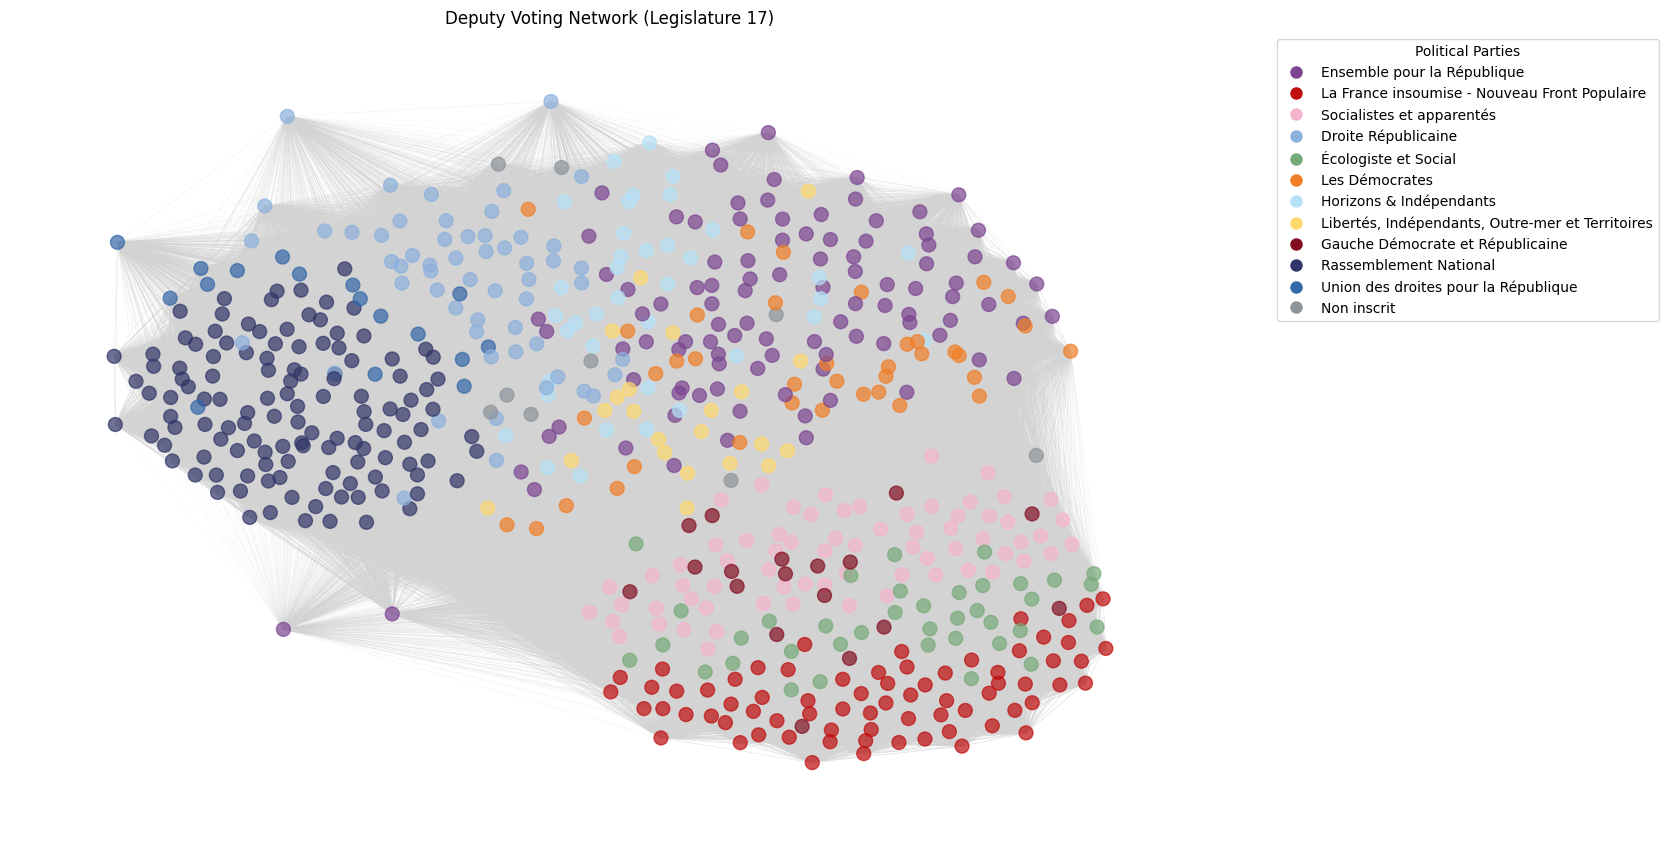

C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\1976495821.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities)
C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\1976495821.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


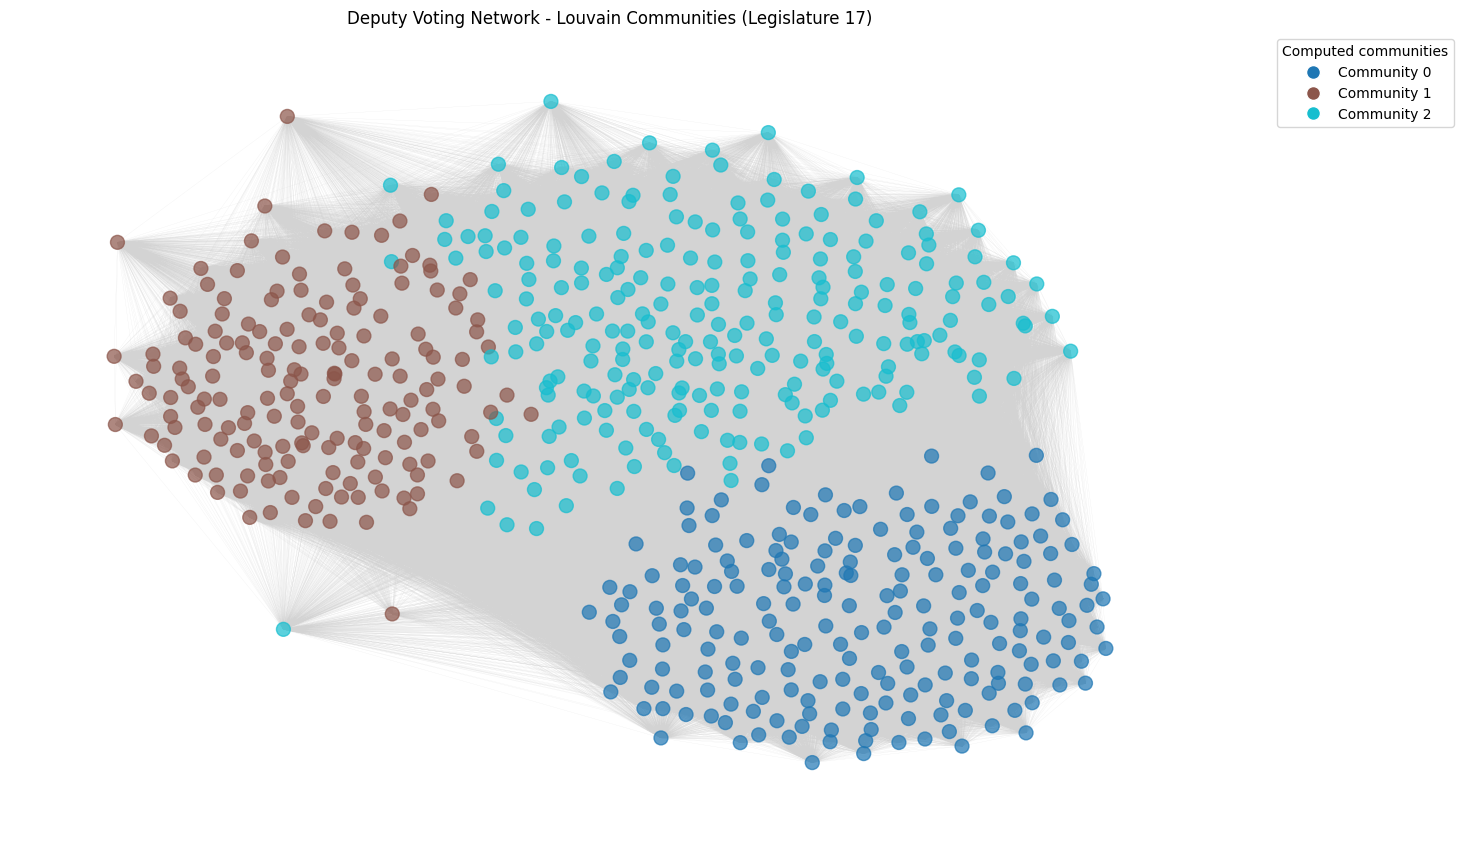

Number of communities: 3
Modularity score: 0.19481303921877247


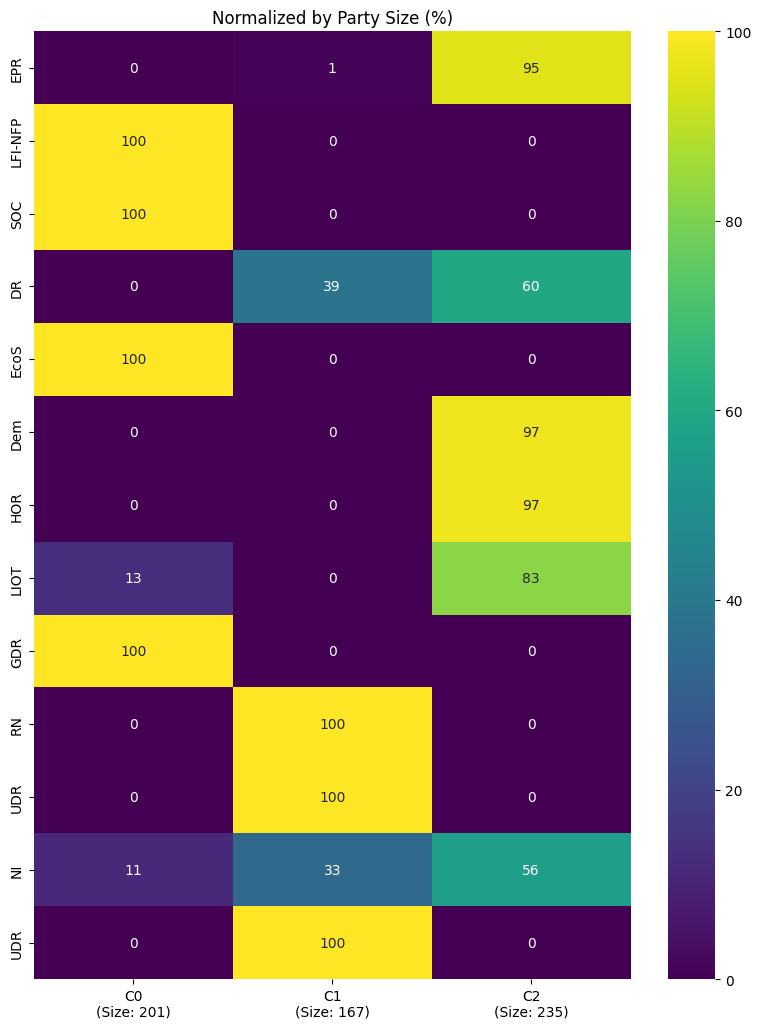

In [118]:
plot_network(G_17, legislature_17["deputies"], 17)
communities_set, modularity_score = detect_communities(G_17, 17)
organ_name_dict, partis_members = get_party_info(legislature_17["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_17["deputies"].keys()))

### Legislature 16

C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\2392156738.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


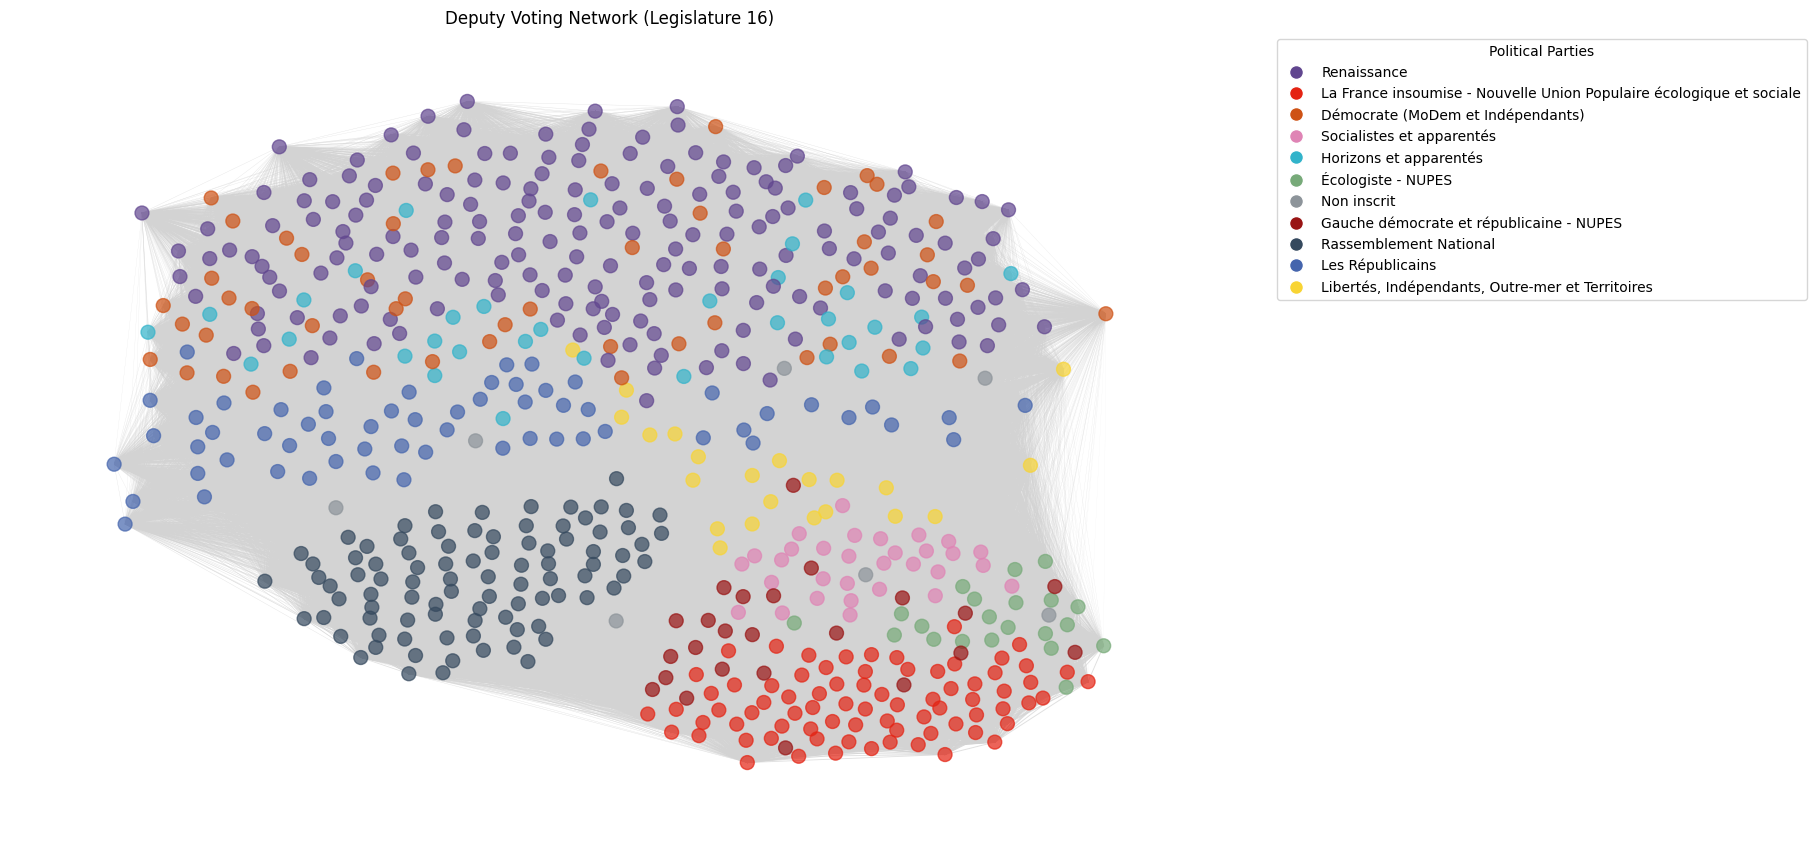

C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\1976495821.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities)
C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\1976495821.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


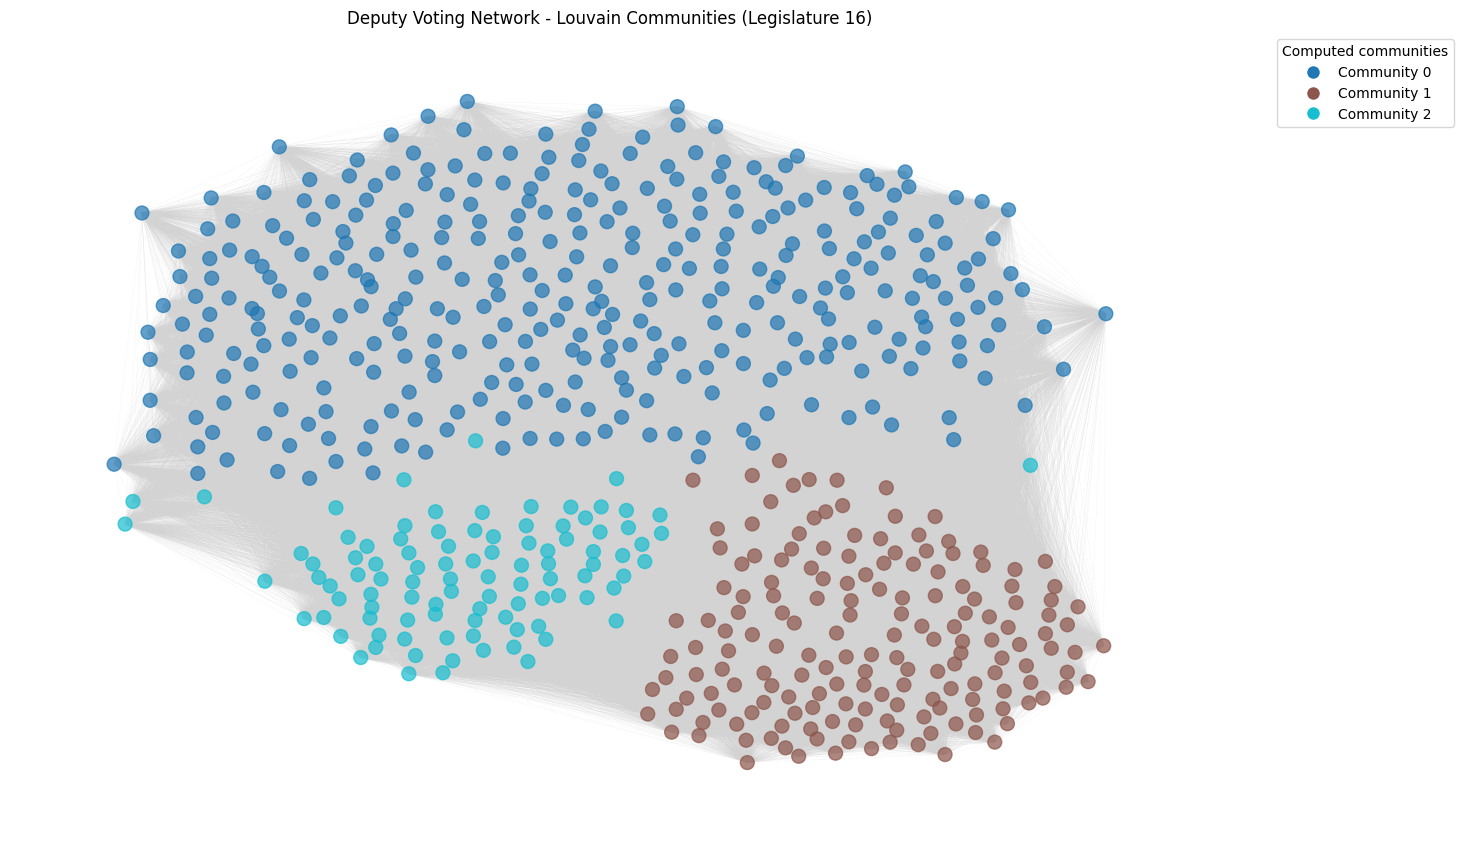

Number of communities: 3
Modularity score: 0.21062038391538115


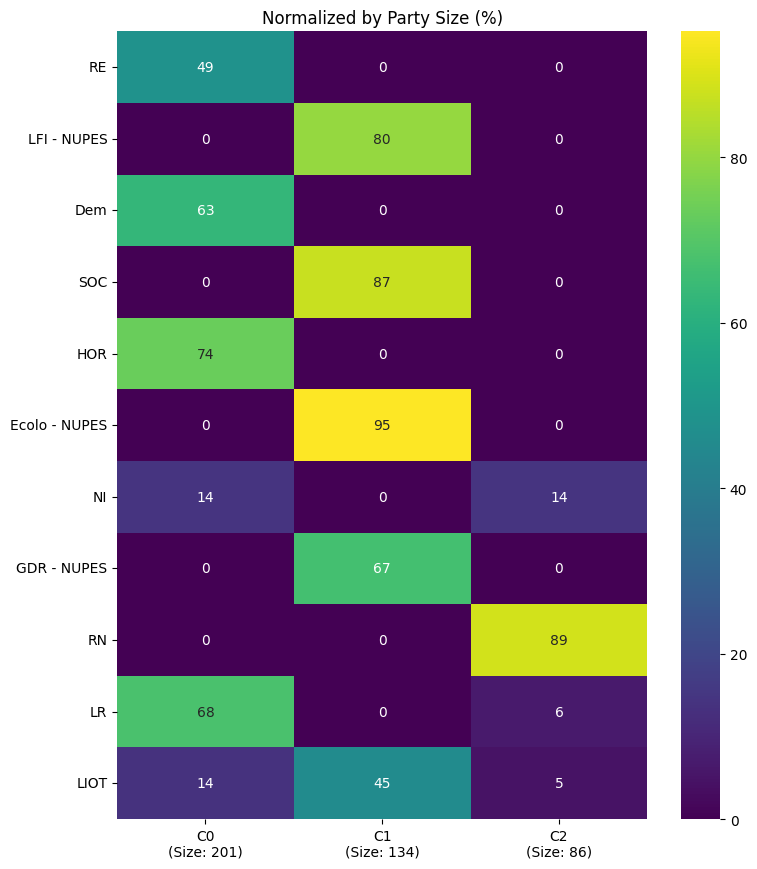

In [114]:
plot_network(G_16, legislature_16["deputies"], 16)
communities_set, modularity_score = detect_communities(G_16, 16)
organ_name_dict, partis_members = get_party_info(legislature_16["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_17["deputies"].keys()))

### Legislature 15

C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\2392156738.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


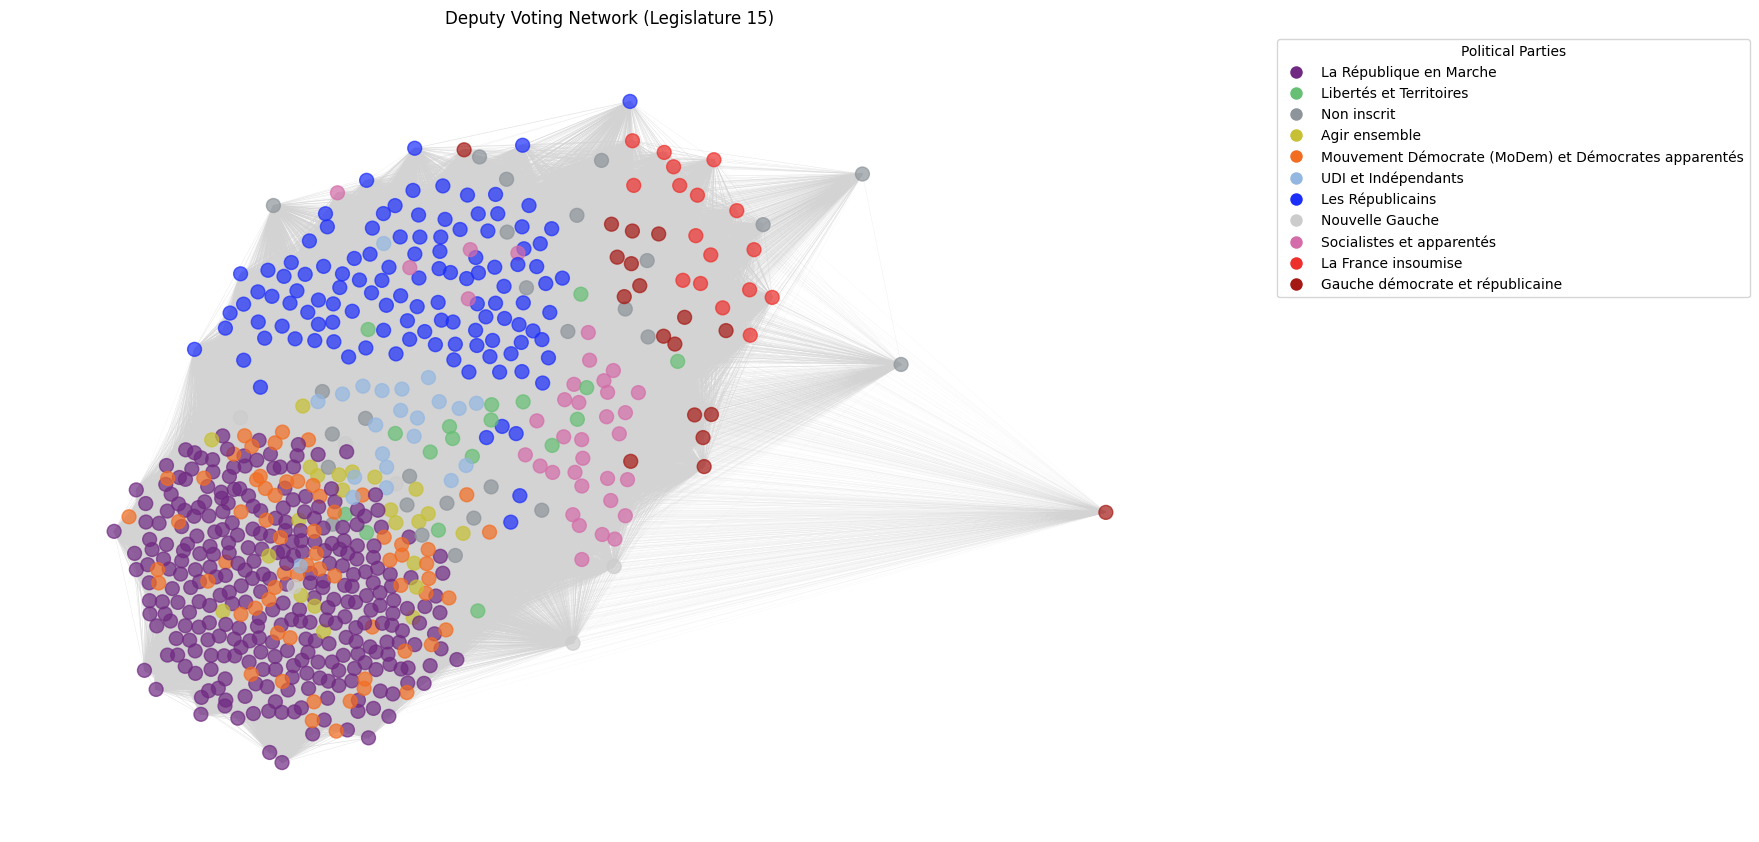

C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\1976495821.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities)
C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\1976495821.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


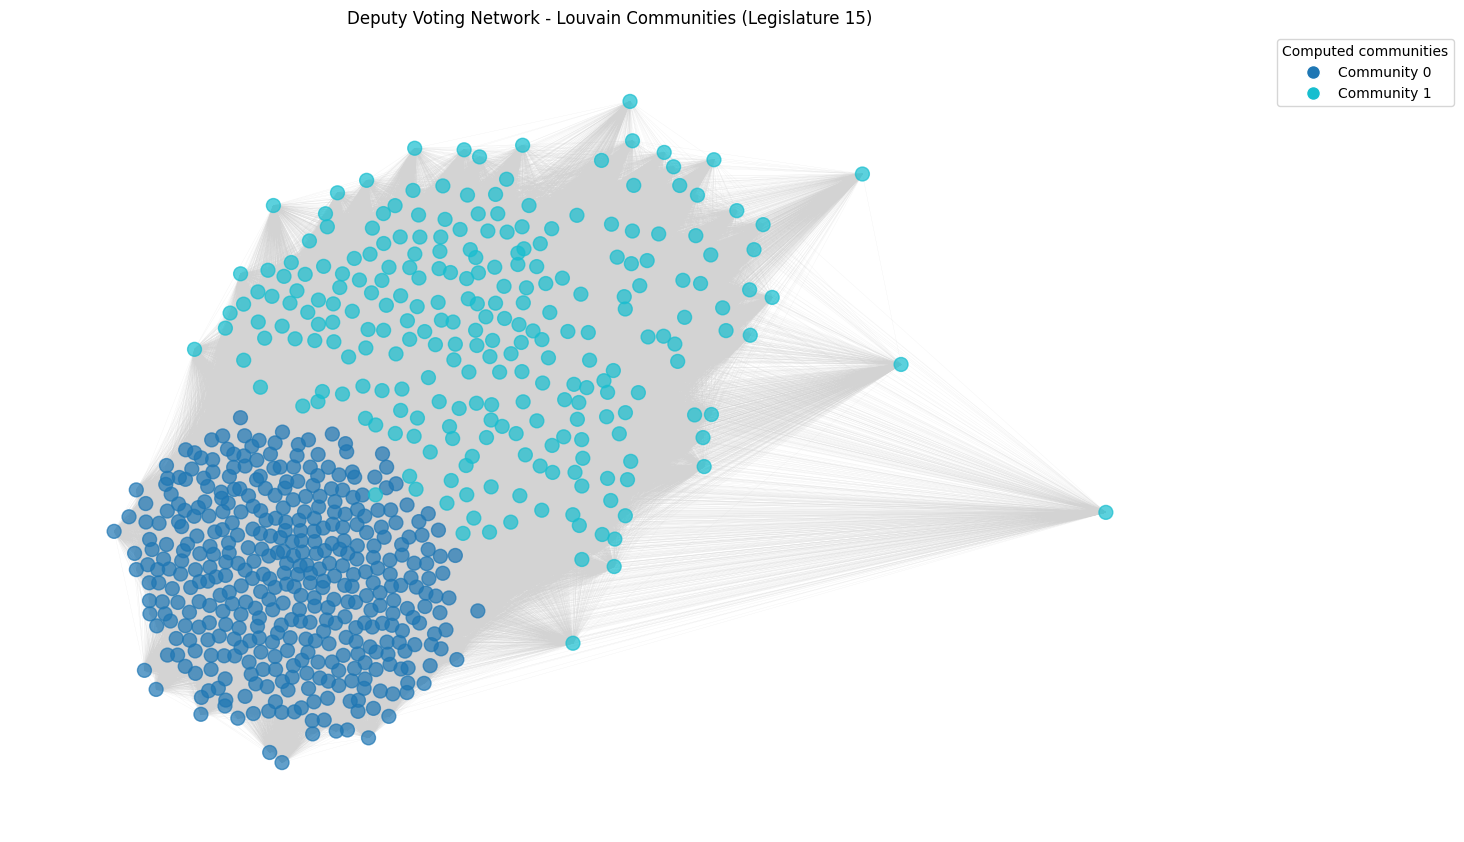

Number of communities: 2
Modularity score: 0.12463631146674277


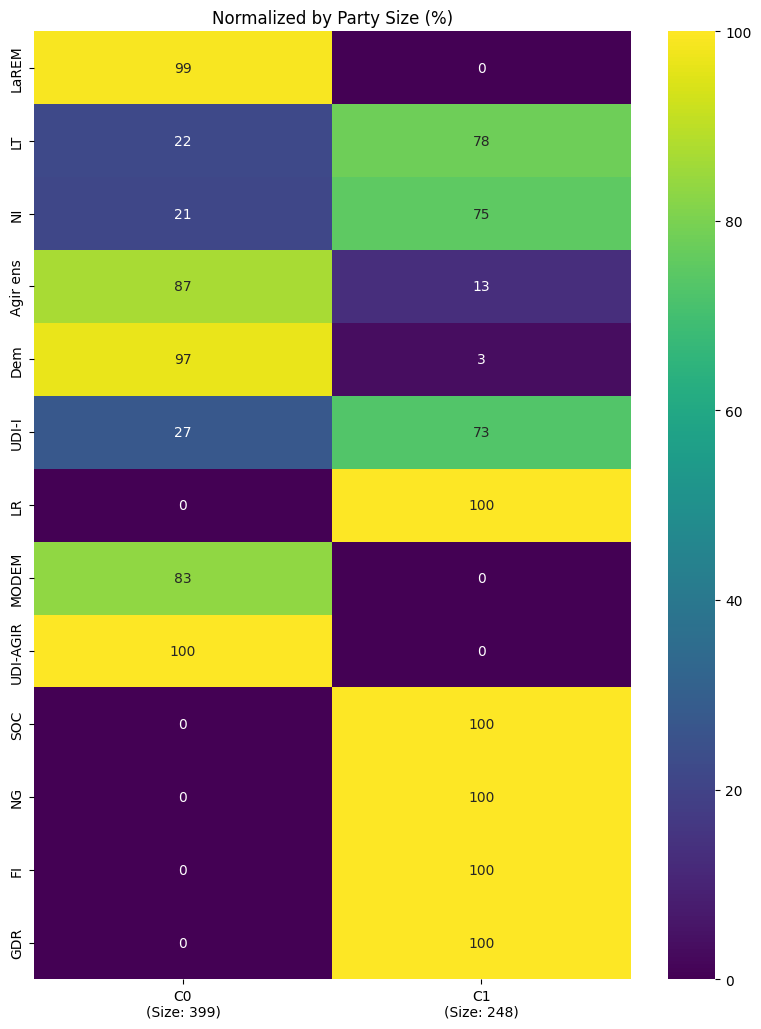

In [115]:
plot_network(G_15, legislature_15["deputies"], 15)
communities_set, modularity_score = detect_communities(G_15, 15)
organ_name_dict, partis_members = get_party_info(legislature_15["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_15["deputies"].keys()))

### Legsilature 14

C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\2392156738.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


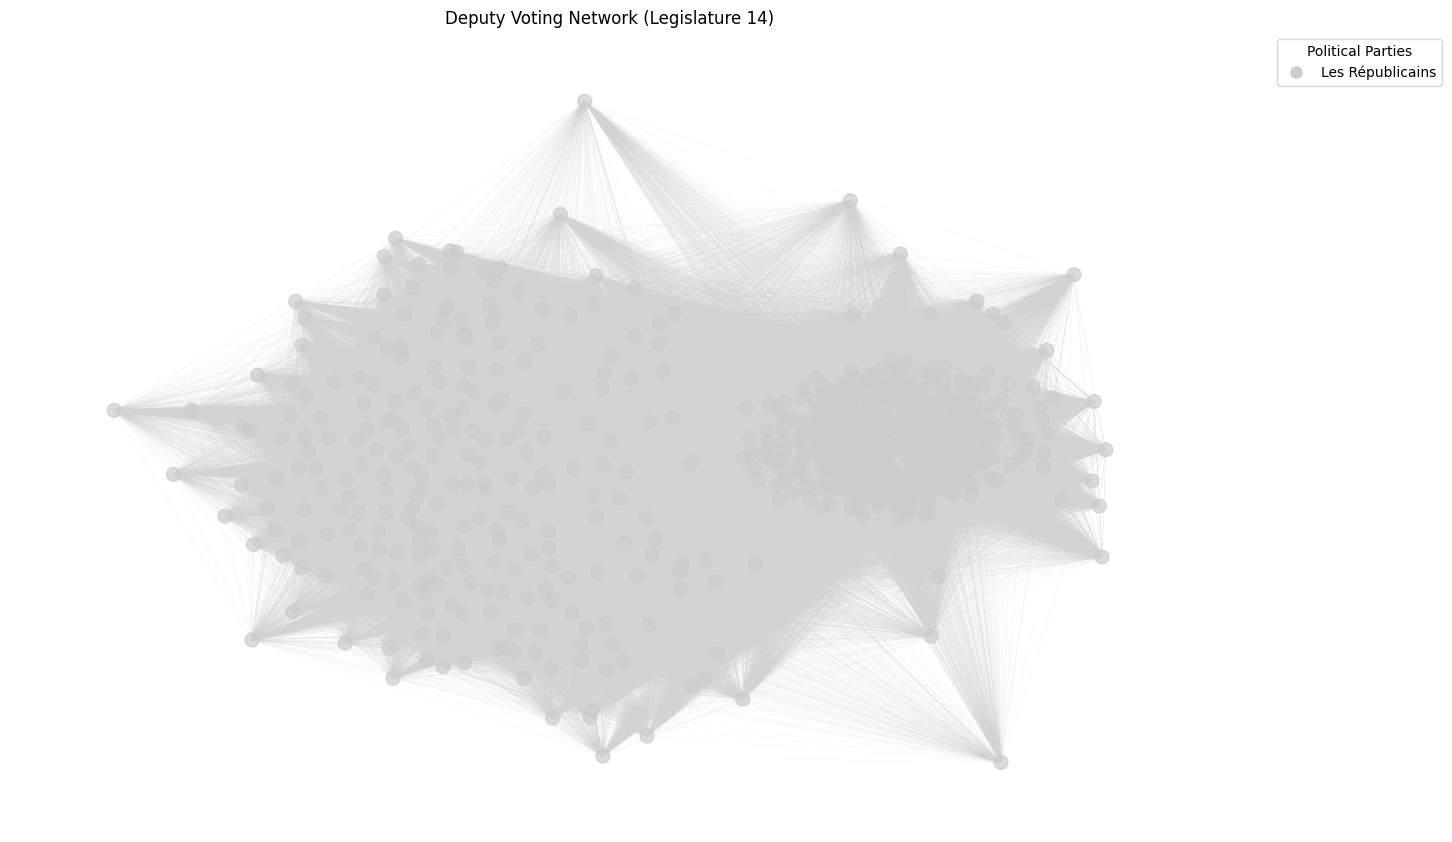

C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\1976495821.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities)
C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\1976495821.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


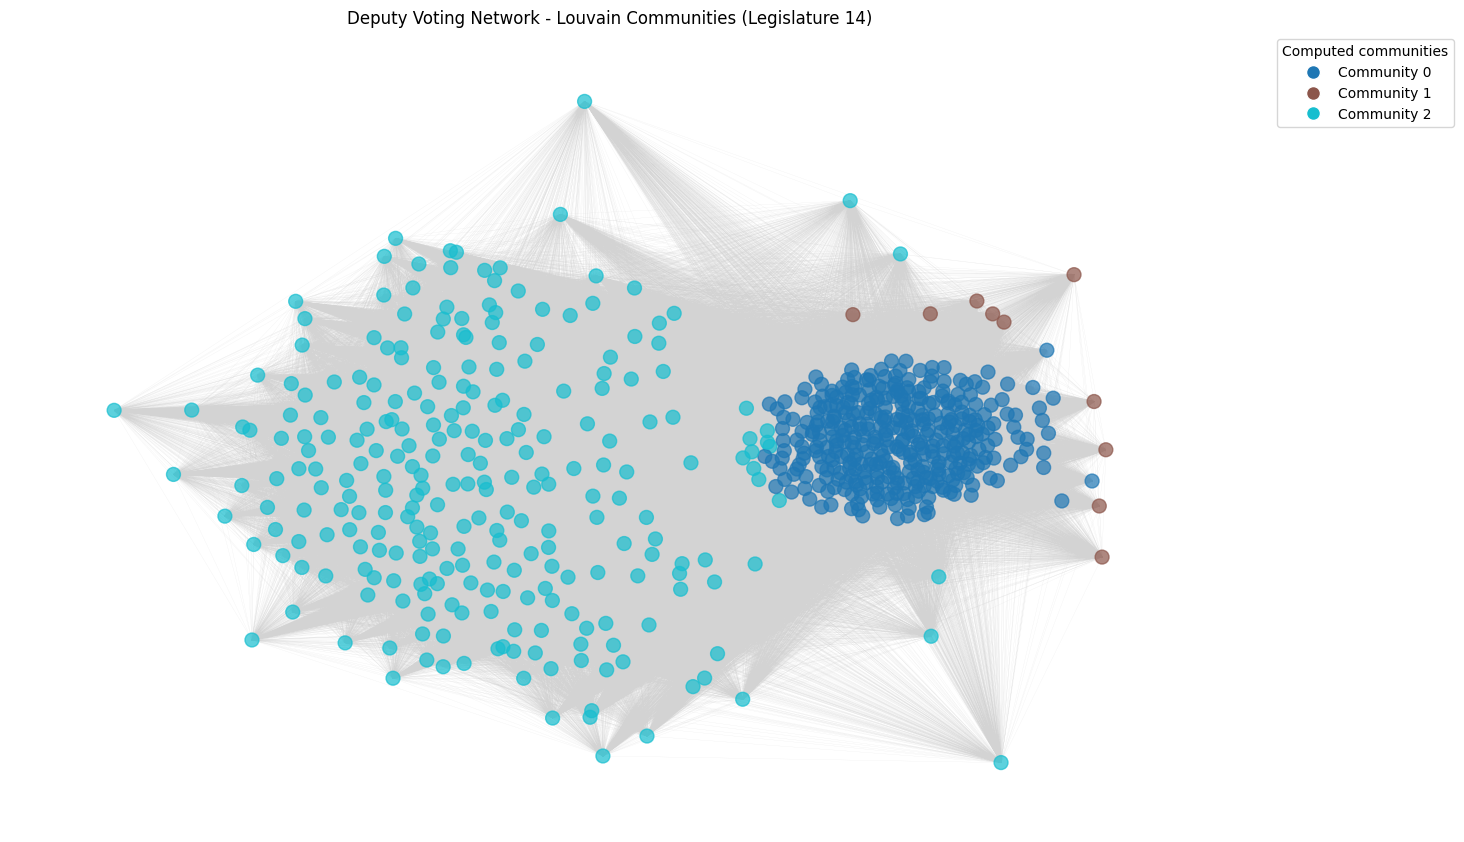

Number of communities: 3
Modularity score: 0.11212378480258245


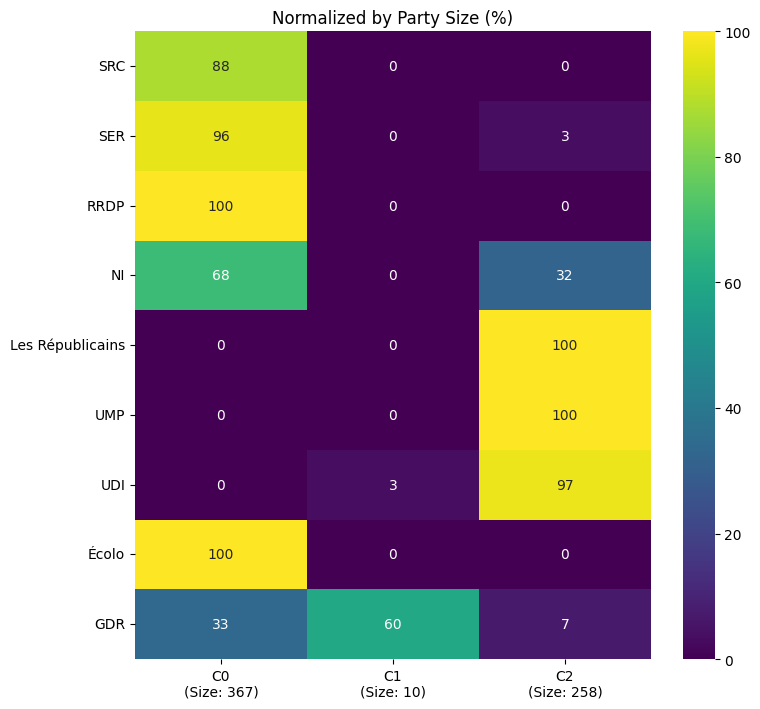

In [116]:
plot_network(G_14, legislature_14["deputies"], 14)
communities_set, modularity_score = detect_communities(G_14, 14)
organ_name_dict, partis_members = get_party_info(legislature_14["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_14["deputies"].keys()))

In [165]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math  # Nécessaire pour le calcul des colonnes
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from collections import Counter

# --- FONCTION DE LISSAGE (Inchangée) ---
def get_smooth_polygon(points, iterations=3, padding=1.1):
    center = np.mean(points, axis=0)
    expanded_points = center + (points - center) * padding
    coords = np.vstack([expanded_points, expanded_points[0]])
    for _ in range(iterations):
        new_coords = []
        for i in range(len(coords) - 1):
            p0, p1 = coords[i], coords[i+1]
            Q = 0.75 * p0 + 0.25 * p1
            R = 0.25 * p0 + 0.75 * p1
            new_coords.extend([Q, R])
        coords = np.array(new_coords)
        coords = np.vstack([coords, coords[0]])
    return coords

# --- FONCTION PRINCIPALE ---
def plot_network_with_communities(G, deputies, legislature_num):
    # 1. PREPARATION
    nodes_color = [deputies[node].get('organ', {}).get('color', '#cccccc') for node in G.nodes()]
    
    party_name_to_color = {}
    party_colors_legend = {}
    for node in G.nodes():
        organ = deputies[node].get('organ', {})
        p_name = organ.get('name_short', 'No name')
        p_color = organ.get('color', '#cccccc')
        party_name_to_color[p_name] = p_color
        party_colors_legend[p_color] = p_name

    communities_set = nx.community.louvain_communities(G, weight="weight")

    # 2. LAYOUT
    G_layout = G.copy()
    for u, v, data in G_layout.edges(data=True):
        data['weight'] = data['weight'] ** 2
    pos = nx.spring_layout(G_layout, k=1, iterations=50, weight='weight', seed=42)

    # 3. DESSIN
    # On ajuste la taille : on garde une grande largeur, et une bonne hauteur 
    # pour accommoder la légende en bas.
    fig, ax = plt.subplots(figsize=(20, 14))

    for i, community_nodes in enumerate(communities_set):
        points = np.array([pos[node] for node in community_nodes])
        
        parties_in_comm = [deputies[node].get('organ', {}).get('name_short', 'No name') for node in community_nodes]
        if parties_in_comm:
            most_common_party_name = Counter(parties_in_comm).most_common(1)[0][0]
            col = party_name_to_color.get(most_common_party_name, '#cccccc')
        else:
            col = '#cccccc'

        if len(points) >= 3:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            smooth_points = get_smooth_polygon(hull_points, iterations=5, padding=1.25)
            
            poly = Polygon(smooth_points, 
                           facecolor='none',       
                           edgecolor=col,          
                           linewidth=4,            
                           linestyle='--',     
                           alpha=1.0,              
                           zorder=2)
            ax.add_patch(poly)
            
            center = np.mean(points, axis=0)
            ax.text(center[0], center[1], f"Com. {i}", 
                     fontsize=30,
                     fontweight='bold', 
                     color=col,            
                     ha='center', va='center',
                     zorder=20,            
                     bbox=dict(facecolor='white', 
                               edgecolor='none', 
                               alpha=1)          
                     )

    # B. DESSINER LES NOEUDS
    nodes = nx.draw_networkx_nodes(G, pos, node_size=120, node_color=nodes_color, 
                                   edgecolors='white', linewidths=0.5, ax=ax)
    if nodes:
        nodes.set_zorder(3)

    # 4. LEGENDES (MODIFIÉ POUR LE BAS)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=name, 
                                 markerfacecolor=color, markersize=15) 
                      for color, name in party_colors_legend.items()]

    # Calcul mathématique pour avoir 2 éléments par colonne (donc 2 lignes au total)
    nb_items = len(legend_handles)
    if nb_items > 0:
        # On divise par 2 et on arrondit au supérieur pour définir le nombre de colonnes
        nb_cols = math.ceil(nb_items / 2)
    else:
        nb_cols = 1

    ax.legend(handles=legend_handles, 
              title="Political Parties", 
              # Positionnement : Centré en haut (loc='upper center') par rapport
              # à une ancre située juste sous le graphe (0.5, -0.05)
              loc='upper center',
              bbox_to_anchor=(0.5, -0.02), 
              ncol=nb_cols,         # Force l'étalement horizontal pour n'avoir que 2 lignes
              fontsize=22,          # Légèrement réduit pour que ça rentre en largeur si beaucoup de partis
              title_fontsize=24,
              frameon=False) 
    
    # TITRE
    ax.set_title(f"Deputy Voting Network with Communities ({str(legislature_num)}'th Legislature)", 
                 fontsize=32,       
                 pad=20)
    
    ax.axis('off')
    
    # MODIFICATION LAYOUT
    # On réserve de l'espace en BAS (bottom=0.15 ou 0.20) pour la légende.
    # On reprend toute la largeur (right=0.95) car la légende n'est plus à droite.
    plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.18)
    
    plt.show()
    
    return communities_set

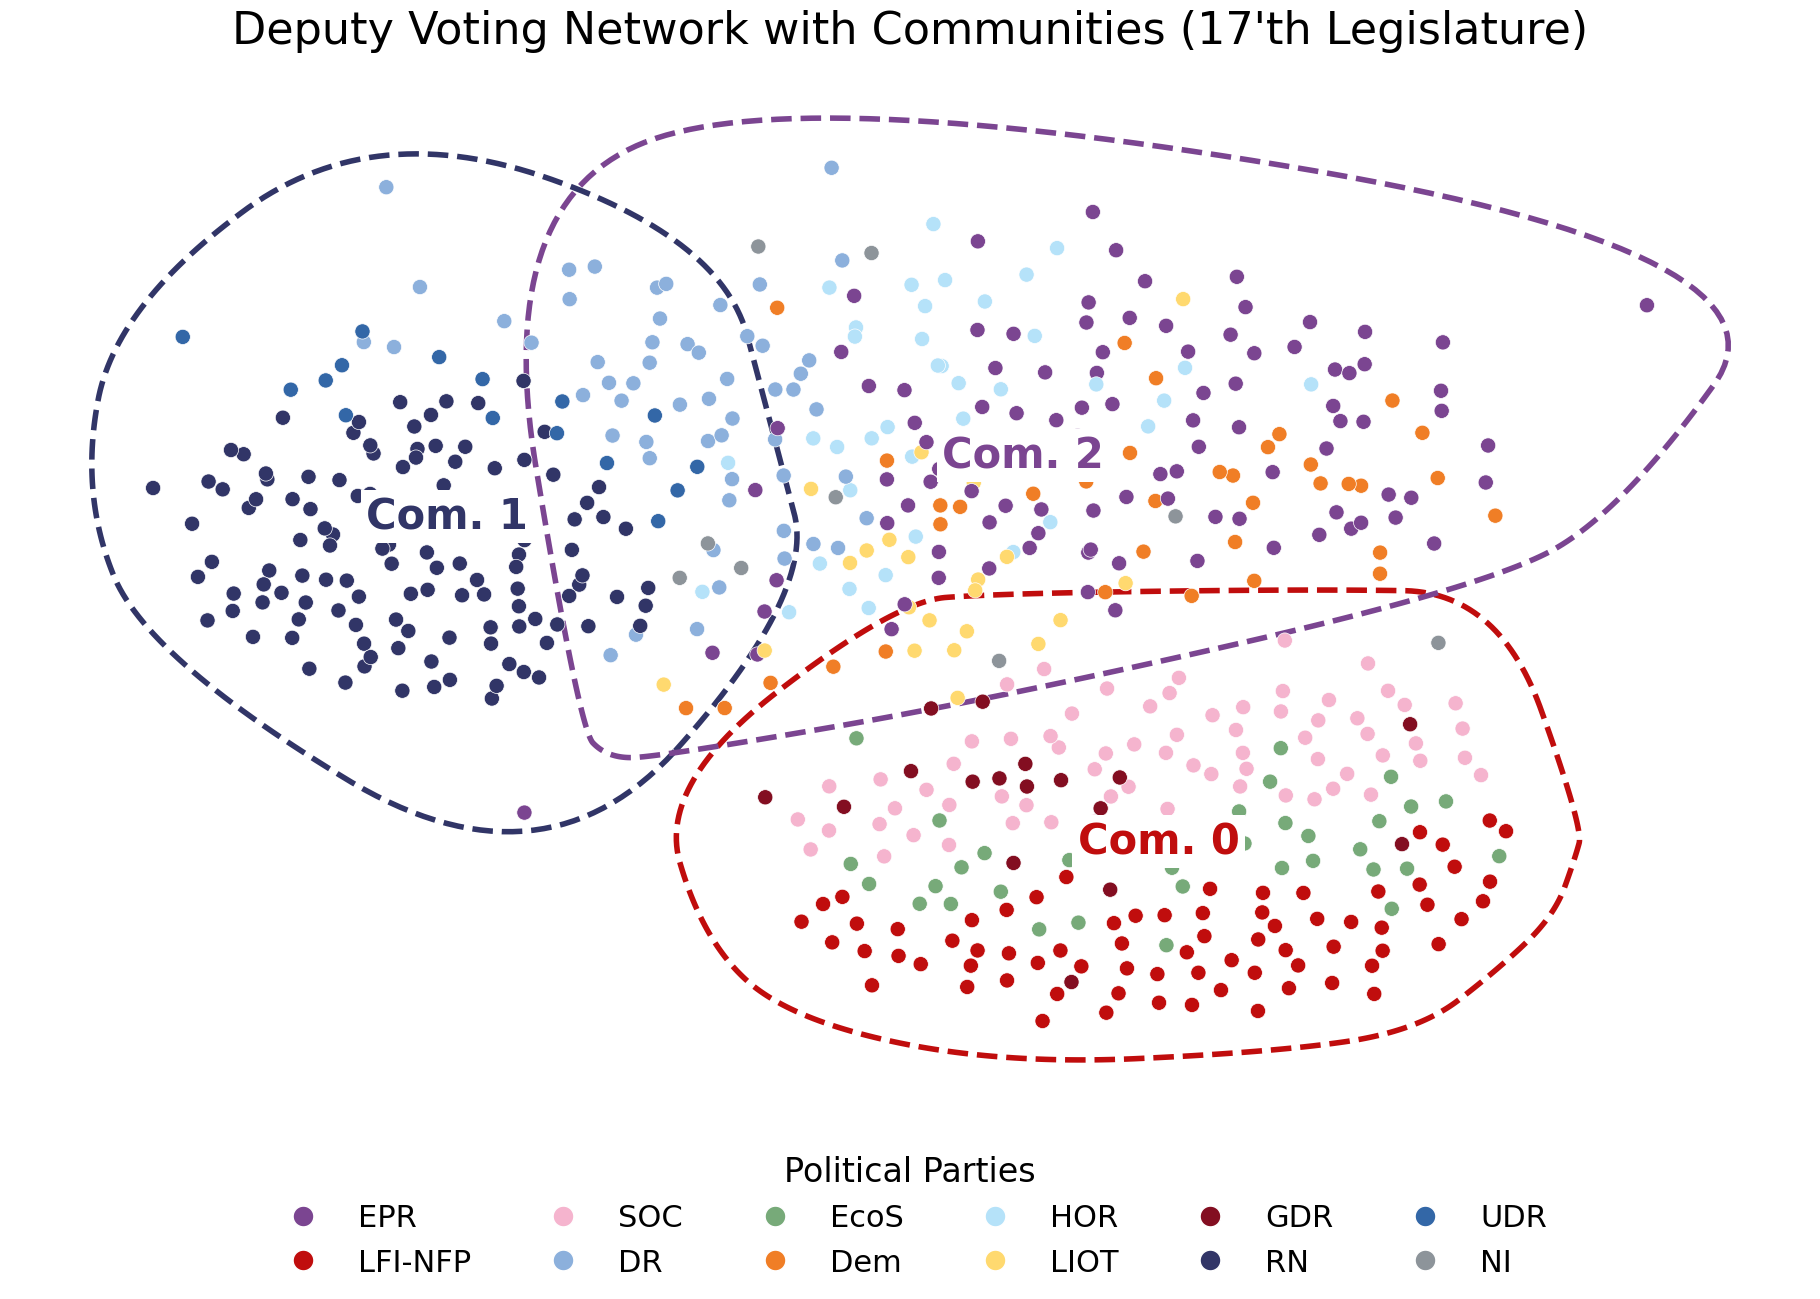

[{'PA1008',
  'PA1567',
  'PA1654',
  'PA267306',
  'PA2940',
  'PA331973',
  'PA333285',
  'PA335054',
  'PA335612',
  'PA335999',
  'PA340343',
  'PA341981',
  'PA342196',
  'PA342384',
  'PA342415',
  'PA588884',
  'PA605745',
  'PA606545',
  'PA606573',
  'PA606793',
  'PA607553',
  'PA607619',
  'PA608172',
  'PA608264',
  'PA609332',
  'PA610002',
  'PA610654',
  'PA610968',
  'PA642764',
  'PA643143',
  'PA643157',
  'PA643175',
  'PA643192',
  'PA719286',
  'PA719578',
  'PA719930',
  'PA720362',
  'PA720430',
  'PA720838',
  'PA720846',
  'PA720892',
  'PA720952',
  'PA720992',
  'PA721062',
  'PA721202',
  'PA721210',
  'PA721270',
  'PA721896',
  'PA721960',
  'PA722142',
  'PA722150',
  'PA736201',
  'PA774958',
  'PA774960',
  'PA774962',
  'PA791812',
  'PA791824',
  'PA793174',
  'PA793262',
  'PA793394',
  'PA793444',
  'PA793452',
  'PA793464',
  'PA793532',
  'PA793624',
  'PA793664',
  'PA793708',
  'PA793736',
  'PA793744',
  'PA793756',
  'PA793772',
  'PA793780',


In [166]:
plot_network_with_communities(G_17, legislature_17["deputies"], 17)

### More detail about legislature 17

Number of nodes: 611
Number of edges: 179915
Average degree: 588.92
Graph has 9 connected components


C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\2392156738.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


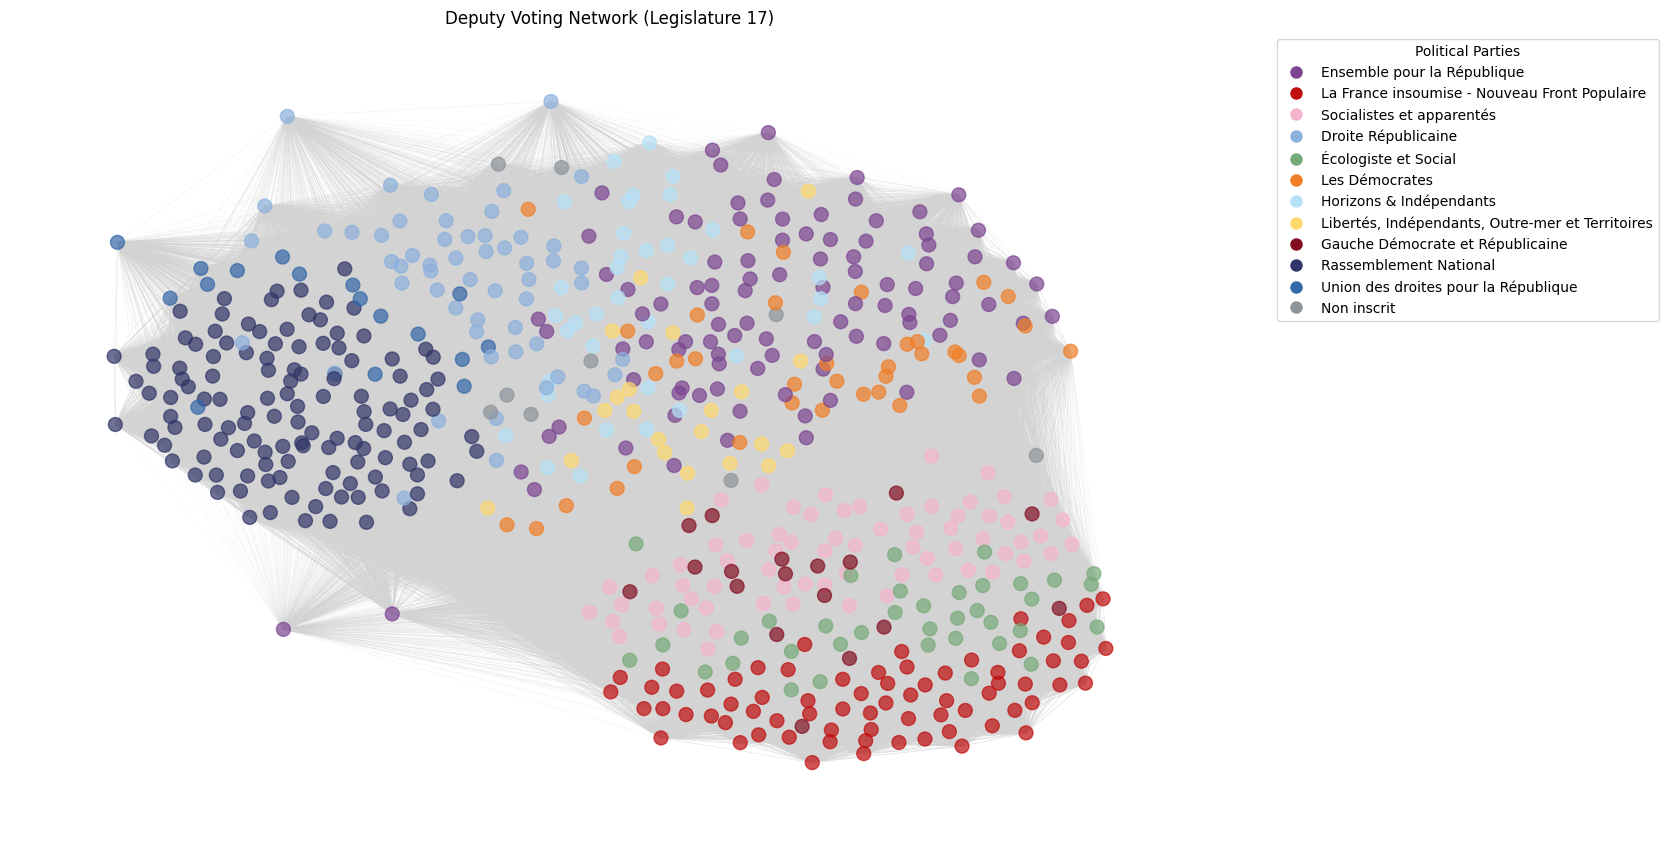

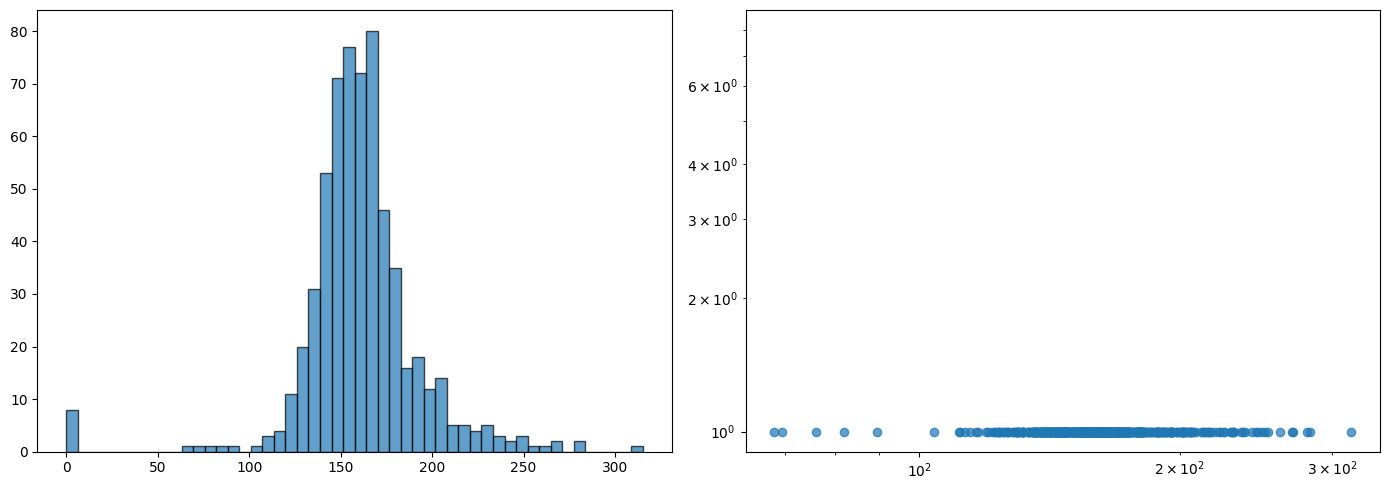

C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\1976495821.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities)
C:\Users\tchir\AppData\Local\Temp\ipykernel_7704\1976495821.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


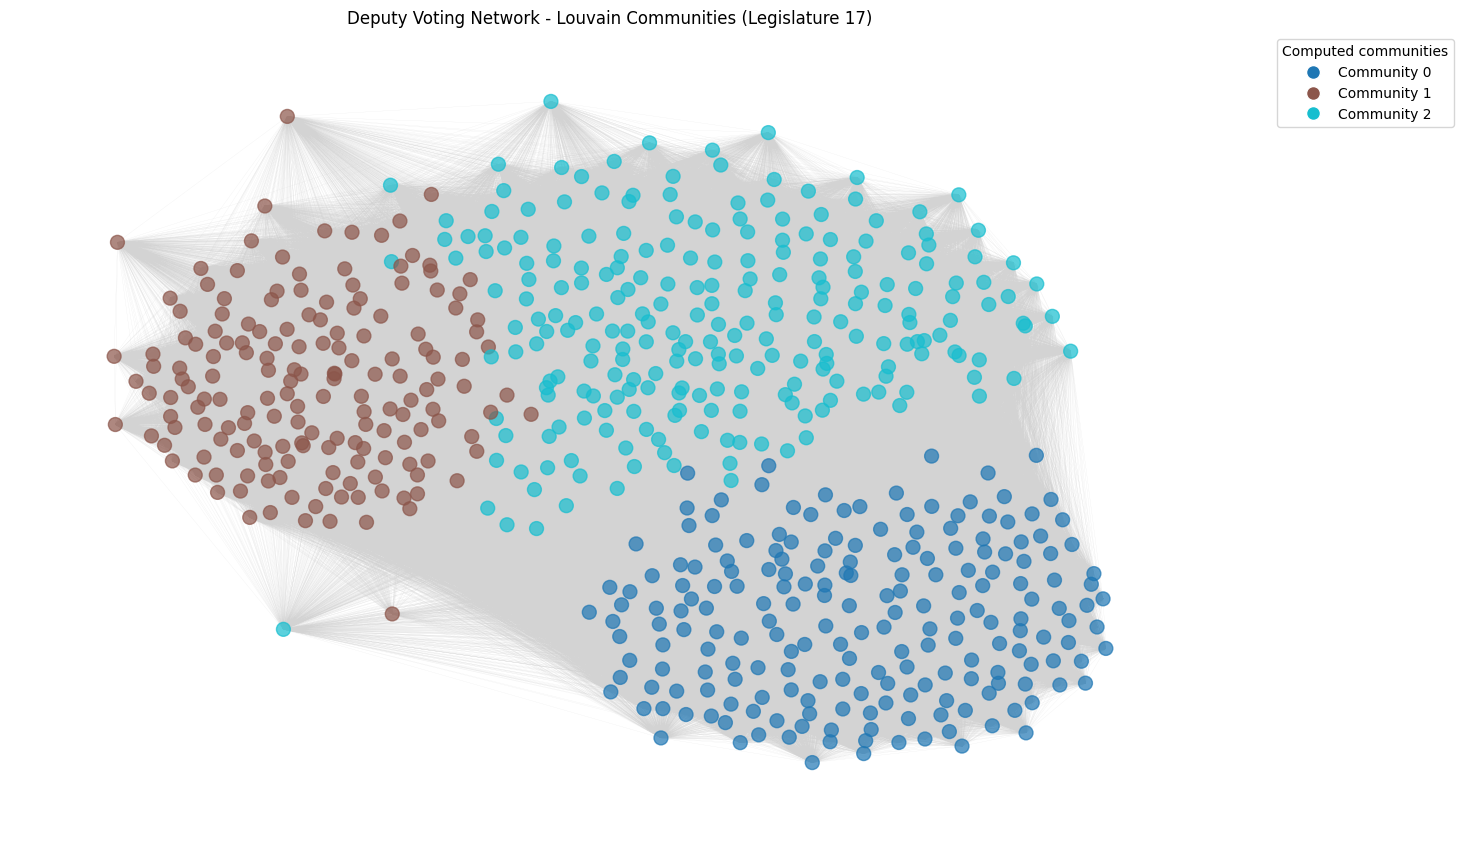

Number of communities: 3
Modularity score: 0.19481303921877277


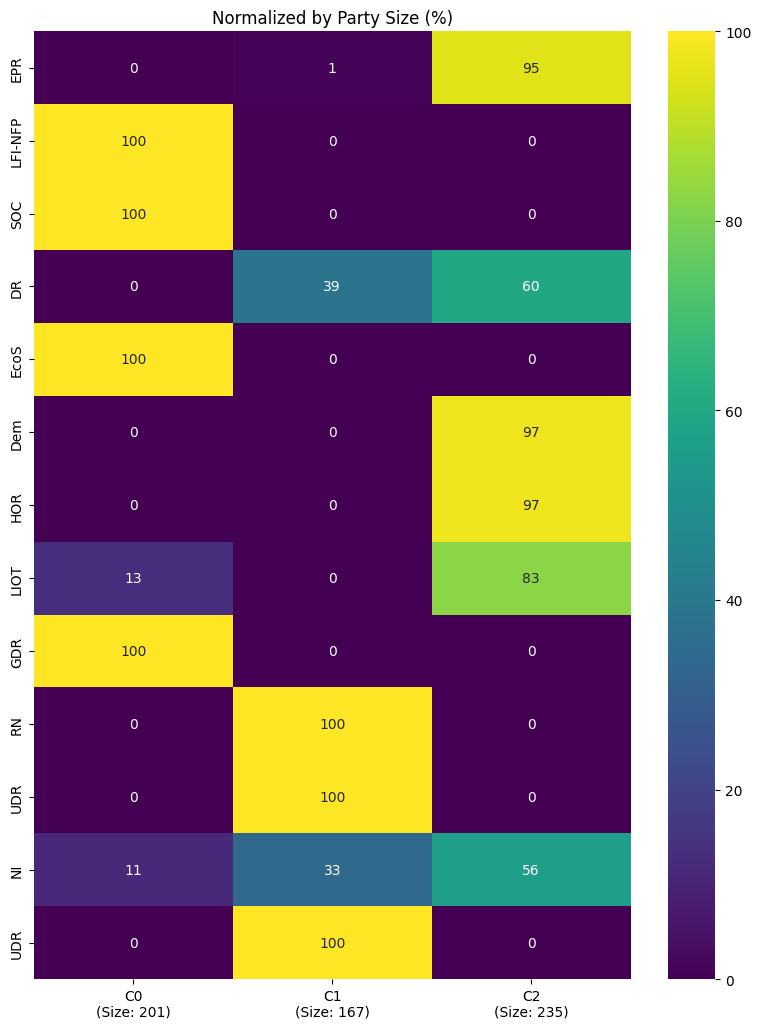

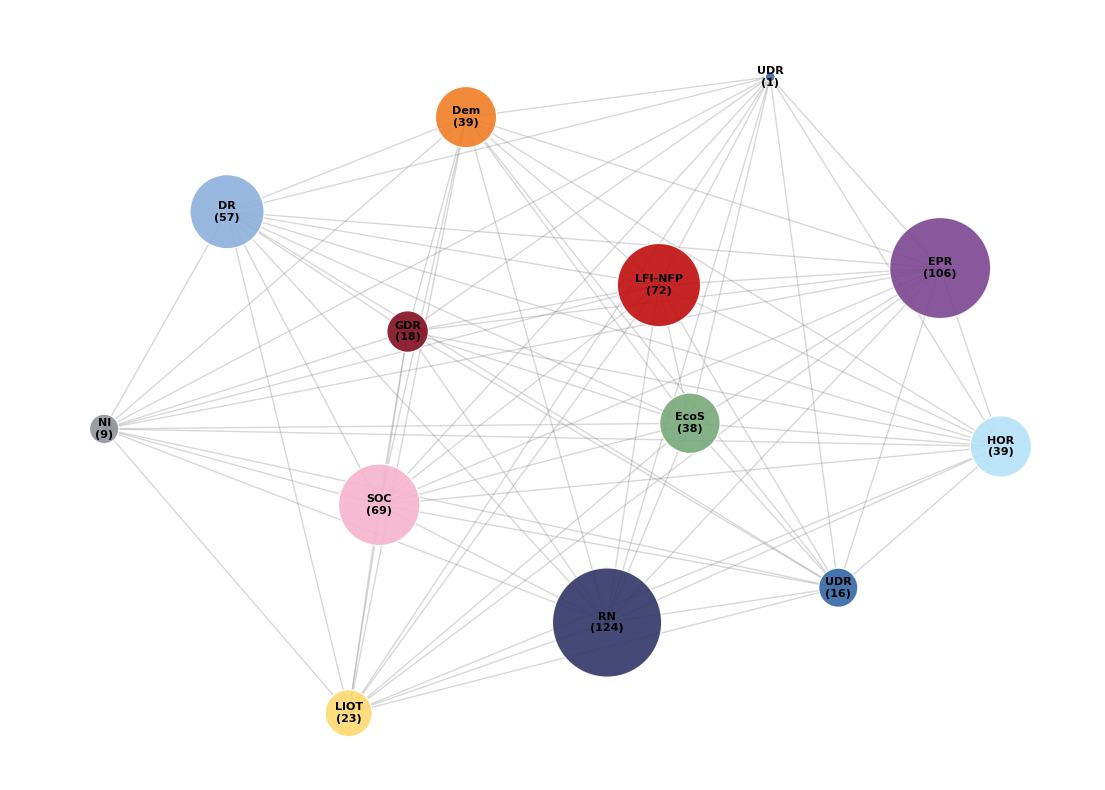

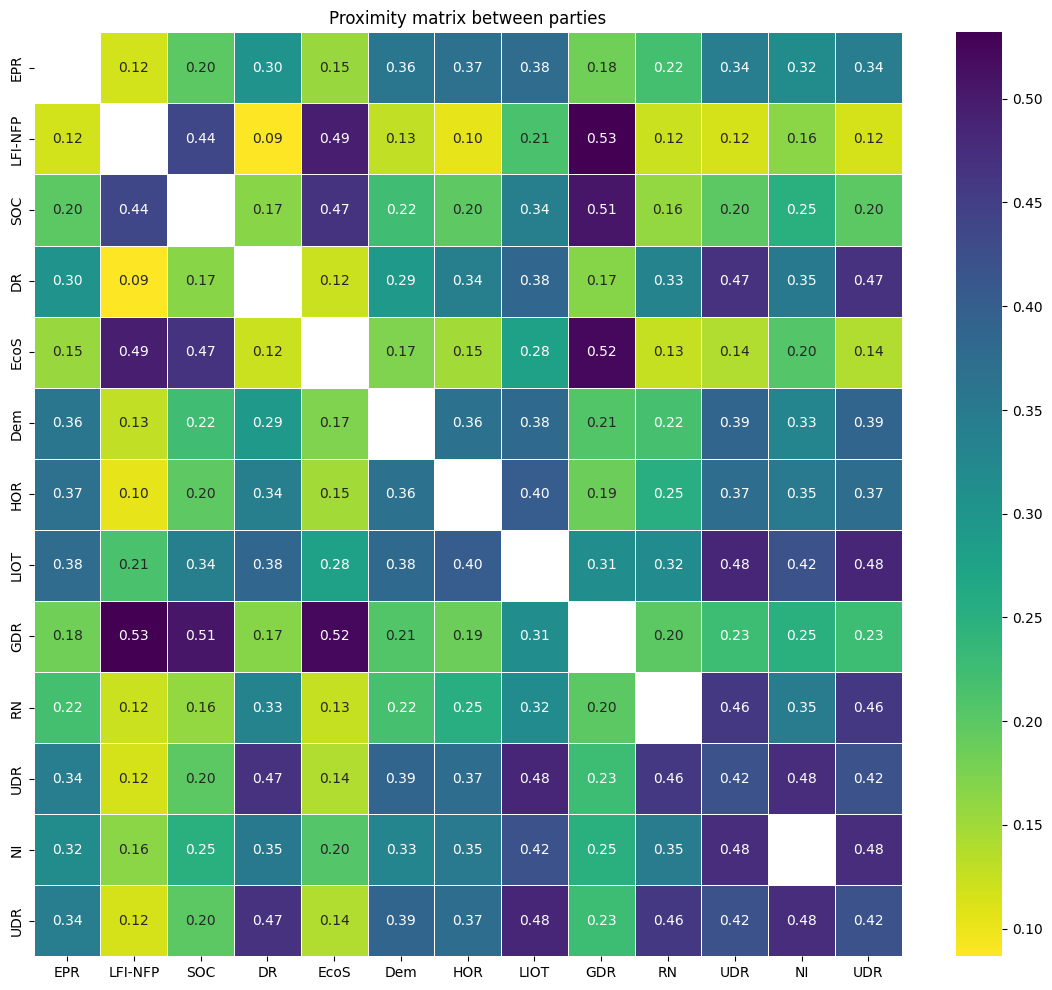

78 159635 181503 21868 12
Modularity score - partis : 0.08543041066076927


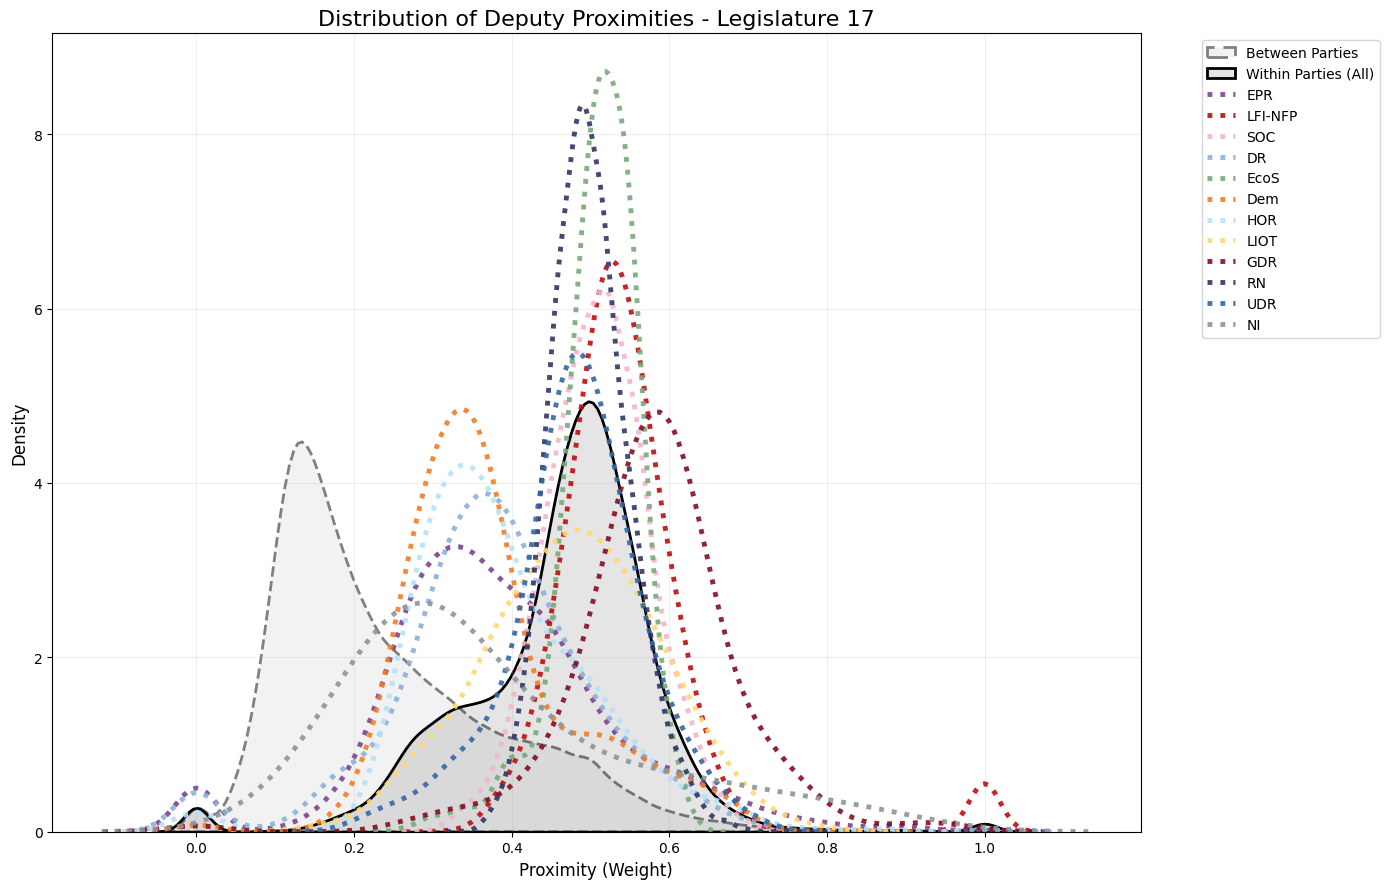

In [117]:
G = create_graph(legislature_17["deputies"], legislature_17["votes"])
print_stats(G)
G_sample = get_giant_component(G)
plot_network(G_sample, legislature_17["deputies"], 17)
plot_degree_distribution(G)
communities_set, modularity_score = detect_communities(G_sample, 17)
organ_name_dict, partis_members = get_party_info(legislature_17["deputies"])
plot_community_matrix(partis_members, communities_set, organ_name_dict, set(legislature_17["deputies"].keys()))
proximites_partis = analyze_party_proximity(G_sample, partis_members, organ_name_dict, legislature_17["deputies"], True)
calculate_party_modularity(G_sample, partis_members)
plot_proximity_comparison(proximites_without_parties_17, proximites_debuties_17, proximites_within_parties_17, proximites_of_parties_17, legislature_17["deputies"], 17)